<a href="https://colab.research.google.com/github/mjavadzadeh11/Crawler/blob/master/Sentimental%20analysis%20using%20Bitcoin%20historical%20datas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GoogleNews
!pip install newspaper3k
#!pip install vaderSentiment;

In [ ]:
!pip install googleanalytics


In [ ]:
import pandas as pd
import datetime as dt
import json
import matplotlib.pyplot as plt
from GoogleNews import GoogleNews
from newspaper import Article
import requests
import nltk
nltk.download('punkt')
from textblob import TextBlob
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [153]:
googlenews = GoogleNews(period='30d')
#googlenews = GoogleNews(start='11/04/2021',end='12/04/2021')
googlenews.search('Iran')
googlenews.get_page(30)
Result=googlenews.results()

In [155]:
def get_news(keyword , period, NumOfPages):
#  ''' keyword is something that will be searched in google , period is the period of search
#  and NumOfPages is how many pages def should search'''
  googlenews = GoogleNews(period='30d')
  googlenews.search('Finance')
  for i in range(2,NumOfPages):
    googlenews.getpage(i)
    result=googlenews.result()
    df=pd.DataFrame(result)
  return df

df=get_news('Bitcoin', '30d',30)

In [156]:
#df.drop(columns=['datetime'], inplace=True)
df.drop(columns=['img'], inplace=True)

In [ ]:
#filtering by media
filt = df['media']== 'Al Jazeera'
df[filt]

In [ ]:
#grouping by media
media_gp= df.groupby(['media'])
media_gp ['link'].value_counts() 

In [157]:

for index in range(df.shape[0]):
  try:
    article=Article(df.loc[index,'link'])
    article.download()
    article.html
    article.parse()
    article.nlp()
    
    
    df.loc[index,'Context'] = article.text
    df.loc[index, 'Summary'] = article.summary
    df.loc[index, 'Keywords'] = ' '.join(article.keywords)
  except:
    df.loc[index,'Context'] = 'Not able to recieve this news'
    df.loc[index, 'Summary'] = 'Could not summarize the context'
    df.loc[index, 'Keywords'] = "No keywords founded"
    

#df['Context'] = news_context

In [102]:
df.loc[:,'datetime']=df.loc[:,'datetime'].apply(lambda x: x.date())

In [103]:

for i in range(df.shape[0]):
  if type(df.loc[i,'datetime']) == pd._libs.tslibs.nattype.NaTType:
    if df.loc[i,'date'].split(' ')[1]=='mins':
      df.loc[i,'datetime'] = dt.date.today()
    elif df.loc[i,'date'].split(' ')[1]=='day':
      df.loc[i,'datetime'] = dt.date.today() - dt.timedelta(1)
    elif df.loc[i,'date'].split(' ')[1]=='days':
      df.loc[i,'datetime'] = dt.date.today() - dt.timedelta(df.loc[i,'date'].split(' ')[0])


In [104]:
df.set_index('datetime', inplace=True)

In [ ]:
df.head()

In [106]:
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

In [107]:
title_polarity=df.loc[:,'title'].apply(get_polarity)
desc_polarity=df.loc[:,'desc'].apply(get_polarity)
df['Polarity']=(title_polarity+desc_polarity)/2

In [ ]:
polarity_avg = df.groupby(['datetime']).mean()
polarity_avg

In [111]:
#getting candel datas from binance
def get_binance_datas (symbol, interval , startTime , endTime):
    ''' symbol="ETHUSDT or BTCUSDT , ..." , interval="1h,4h,8h,12h,1d", times = dt.datetime(2020,1,1) '''
    
    url = "https://api.binance.com/api/v3/klines"
    startTime= str(int(startTime.timestamp()*1000))
    endTime= str(int(endTime.timestamp()*1000))
    limit ="1000"
    req_p = {"symbol" : symbol , "interval": interval , 'startTime':startTime , 'endTime':endTime , 'limit':limit}
    response = pd.DataFrame(json.loads(requests.get(url , params = req_p).text))
    if len(response.index)==0 :
        return None
    response=response.iloc[:,0:6]
    response.columns=['Datetime' , 'Open' , 'High' , 'Low' , 'Close' , 'Volume' ]
    response['Datetime'] = [dt.datetime.fromtimestamp(x/1000) for x in response['Datetime']]
    response.set_index(['Datetime'] , inplace=True)
    return response
    

In [121]:
df1=get_binance_datas('BTCUSDT' , '1d' , dt.datetime (2021,11,23) , dt.datetime(2021,12,7))

In [144]:

df1['Mean'] = (df1.loc[:,'Open'].apply(float) + df1.loc[:,'Close'].apply(float)) / 2

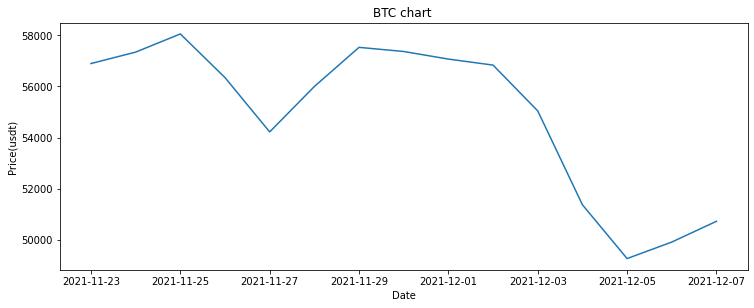

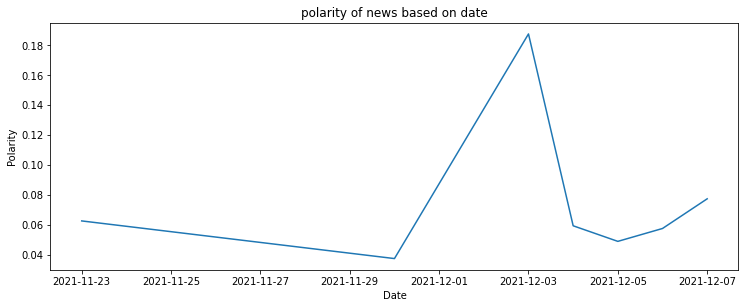

In [152]:
#plot 1 BTC daily chart
plt.figure(figsize=(12.33 , 10))
plt.subplot(2, 1, 1)
plt.plot(df1.index ,df1.Mean)
plt.title('BTC chart ')
plt.xlabel('Date')
plt.ylabel('Price(usdt)')

# plot 2 news impact

plt.figure(figsize=(12.33 , 10))
plt.subplot(2, 1, 2)
plt.plot(polarity_avg.index ,polarity_avg)
plt.title('polarity of news based on date')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.show()